## TOC:
* [Fillout NA](#1.5-Fillout-NA)
* [Numerical Attibutes](#1.7.1-Numerical-Attributes)

# 0.0. IMPORTS

In [ ]:
## TOC:
* [ 0.0. IMPORTS](#first-bullet)
* [Second Bullet Header](#second-bullet)

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import inflection
import math

## 0.1. Helper Functions

## 0.2. Loading data

In [40]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory = False)
df_store_raw = pd.read_csv( 'data/store.csv', low_memory = False)

# merge
df_raw = pd.merge(df_sales_raw,df_store_raw, how='left', on = 'Store' )

# 1.0. DESCRICAO DOS DADOS

In [41]:
# é interessante copiar o df no início de cada seção para evitar que, caso seja alterado o conteúdo do df, não seja necessário rodar todo o código novamente
df1 = df_raw.copy()

## 1.1. Rename Columns

In [42]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))
df1.columns = cols_new

## 1.2 Data Dimensions

In [43]:
# imprimir o número de linhas e colunas usando 2 maneiras de interpolar strings
print(f'Number of Rows: {df1.shape[0]}')
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [44]:
# inicialmente, o date é object
# deve-se alterar o tipo do date
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [45]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [46]:
df1["promo2"].value_counts()

1    509178
0    508031
Name: promo2, dtype: int64

## 1.5 Fillout NA

Existem 3 métodos principais: <br>
    - Removo todas as linhas com NA, que possui a imensa desvantagem de perder muita informação
    - Uso algum algoritmo para preencher os dados NA, como média, mediana ou algum ML para estimar os valores
    - Entender a razão pela qual é NA; sempre devo começar por este método, pois eventualmente o NA era esperado
    

In [47]:
#competition_distance: distance in meters to the nearest competitor store

# o código abaixo revela que existem 3 lojas (622, 291 e 879) que possuem esta coluna em branco
stores = df1[df1["competition_distance"].isna()]["store"].value_counts()
display(stores)
print("\n")

# o código abaixo revela que existem as mesmas quantidades de linhas que trazem os dados destas stores em relação
# à quantidade de linhas com o valor da distância do competidor mais próximo
for store in stores.index:
    print(df1[df1["store"] == store].shape[0])
print("\n")  
    
# portanto, é razoável assumir que este valor NA para a competition distance significa que não há loja competidora próxima
# será então substituída por um vlaor muito maior que a distância máxima
# antes, precisamos saber o a distância máxima presente no dataset
print((df1["competition_distance"].max()))
print("\n") 

# sabendo que a distância máximo é 75860, podemos substituir por 200.000, por exemplo
df1["competition_distance"] = df1["competition_distance"].fillna(200000)

# finalmente, checando se atribuiu corretamente
print("Após a modificação, agora há " + str(df1["competition_distance"].isna().sum()) + " valor faltante")

622    942
291    942
879    758
Name: store, dtype: int64



942
942
758


75860.0


Após a modificação, agora há 0 valor faltante


In [48]:
#competition_open_since_month:  gives the approximate year and month of the time the nearest competitor was opened

# para a primeira interação do CRISP, para aquelas lojas que eu não tenho a informação sobre quando a loja competidora abriu,
# vou simplesmente alocar o mesmo mês da linha de venda. Mesmo não sendo lógico, se for preciso na segunda interação do método CRISP
# poderei alterar esta atribuição.
# um motivo para essa suposição é que o mês e ano que uma loja competidora abriu pode significar um evento no comportamento de vendas
# tal evento pode ser detectado lá no feature selection
# logo, se o mês e ano da loja competidora "acompanham" o mês e ano da data da venda, não haverá nenhuma consequência nas vendas para as linhas que
# inicialmente estavam NA


x = lambda x: x["date"].month if math.isnan(x["competition_open_since_month"]) else x["competition_open_since_month"]
df1["competition_open_since_month"] = df1.apply(x, axis=1)

# o mesmo raciocínio para o "competition_open_since_month" vale para o "competition_open_since_year", promo2_since_week e promo2_since_year
#competition_open_since_year
x = lambda x: x["date"].year if math.isnan(x["competition_open_since_year"]) else x["competition_open_since_year"]
df1["competition_open_since_year"] = df1.apply(x, axis=1)

#promo2_since_week
x = lambda x: x["date"].week if math.isnan(x["promo2_since_week"]) else x["promo2_since_week"]
df1["promo2_since_week"] = df1.apply(x, axis=1)

#promo2_since_year
x = lambda x: x["date"].year if math.isnan(x["promo2_since_year"]) else x["promo2_since_year"]
df1["promo2_since_year"] = df1.apply(x, axis=1)


In [49]:
#promo_interval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. 
#E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# para a primeira rodada do CRISP, será atribuído o valor 0 (zero) para os dados faltantes da coluna "promo_interval"
df1["promo_interval"].fillna(0, inplace = True)

# a seguir, será verificado se o mês da data da linha é mês de início de rodada da promo2 e atribuído à nova coluna "is_promo:
# 0 (quando não é mês de de início) ou 1 (quando é mês de início)
month_map = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug",9: "Sept", 10: "Oct", 11: "Nov",12: "Dec"}
df1["month_map"] = df1["date"].dt.month.map(month_map)

# escrevi 2 maneiras de executar a função que popula a nova coluna "is_promo"
# a primeira demora +10 min e por isso foi inteiramente comentada:

#def isPromo(df):
#    if df["promo_interval"] == 0:
#        df["is_promo"] = 0
#    else:
#        if df["month_map"] in df["promo_interval"].split(','):
#            df["is_promo"] = 1
#        else:
#            df["is_promo"] = 0
#    return df
            
# df1["is_promo"] = df1[["promo_interval","month_map"]].apply(isPromo, axis = 1)["is_promo"]
# Last executed at 2021-04-08 09:14:02 in 13m 57.15s


# a segunda demora menos de 15 segundos:
df1["is_promo"] = df1[["promo_interval","month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split(',') else 0, axis = 1)
# Last executed at 2021-04-08 08:53:43 in 11.97s

In [50]:
# confirma que todos os dados faltantes foram tratados
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types


In [51]:
# as operações realizadas em 1.5 podem ter mudado os tipos das colunas.
# por isso é importante checar novamente
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [52]:
# mudar o tipo das colunas que tem semana, mês e ano
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)
df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)
df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)

# a princípio não há nenhum problema em deixar algumas colunas como int32 e outras como int64
# caso seja necessária a conversão: valor_64 = np.int64(valor_a_ser_convertido)

## 1.7 Descriptive Statistical

Métricas: <br>
* Tendência central: média, mediana
* Dispersão: variância, desvio padrão, amplitude

Embora a estatística descritiva seja compatível com dados numéricos e categóricos, a forma de construção é diferente. Portanto, preciso separar em dados numéricos e dados categóricos.

In [53]:
num_attributes = df1.select_dtypes(include=['int32', 'int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int32', 'int64', 'float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [54]:
# mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.skew()).T
d6 = pd.DataFrame(num_attributes.kurtosis()).T

# concat
metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
metrics.columns = ['attributes', 'min','max','range','mean','median','std','skew','kurtosis']


In [55]:
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='sales', ylabel='Count'>

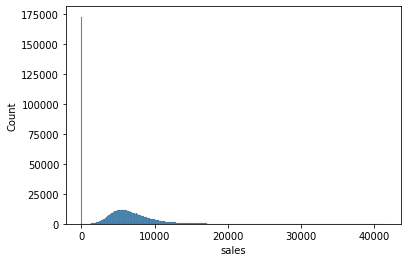

In [56]:
sns.histplot(df1["sales"])

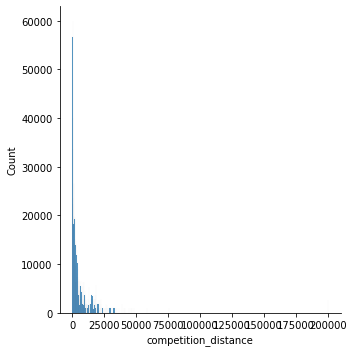

In [57]:
sns.displot(df1["competition_distance"])

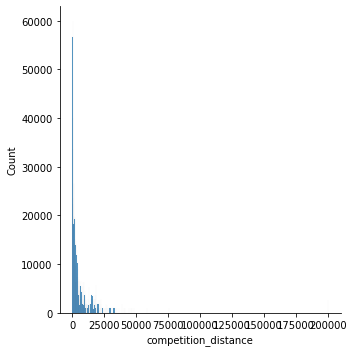

In [58]:
sns.displot(df1["competition_distance"])

### 1.7.2 Categorical Attributes

In [59]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

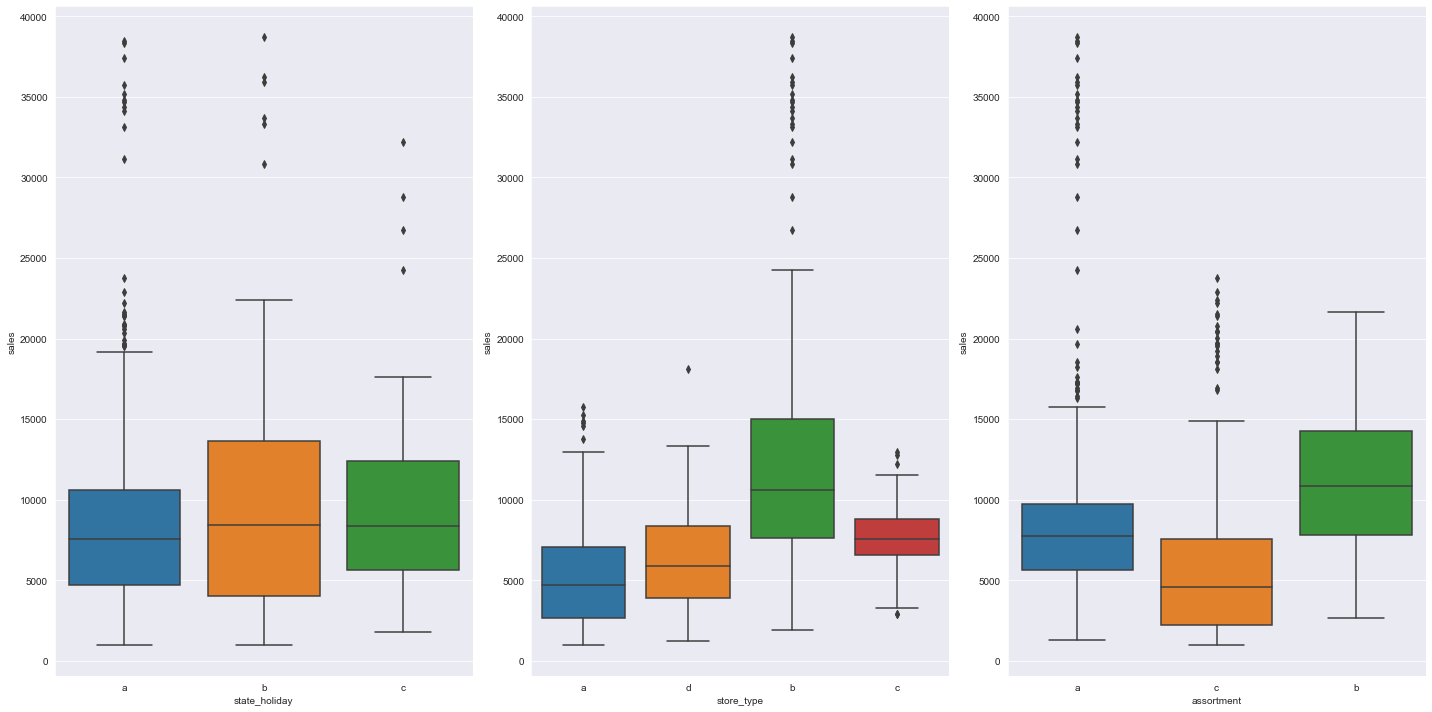

In [88]:
aux1 = df1[(df1["state_holiday"] != '0') & (df1["sales"] > 0)]
sns.set_style("darkgrid")
plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
sns.boxplot(x="state_holiday", y="sales", data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x="store_type", y="sales", data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x="assortment", y="sales", data=aux1)

plt.tight_layout()